# Continuous Kang-Schafer Simulation
Notebook contains Integration of 

Running well-specified continuous Kang-Schafer simulation...
  Sample size: 100
    Simulation 1/5
  Sample size: 250
    Simulation 1/5
  Sample size: 500
    Simulation 1/5
  Sample size: 1000
    Simulation 1/5
Well-specified simulation completed in 68.1 seconds
Running misspecified continuous Kang-Schafer simulation...
  Sample size: 100
    Simulation 1/5
  Sample size: 250
    Simulation 1/5
  Sample size: 500
    Simulation 1/5
  Sample size: 1000
    Simulation 1/5
Misspecified simulation completed in 231.5 seconds


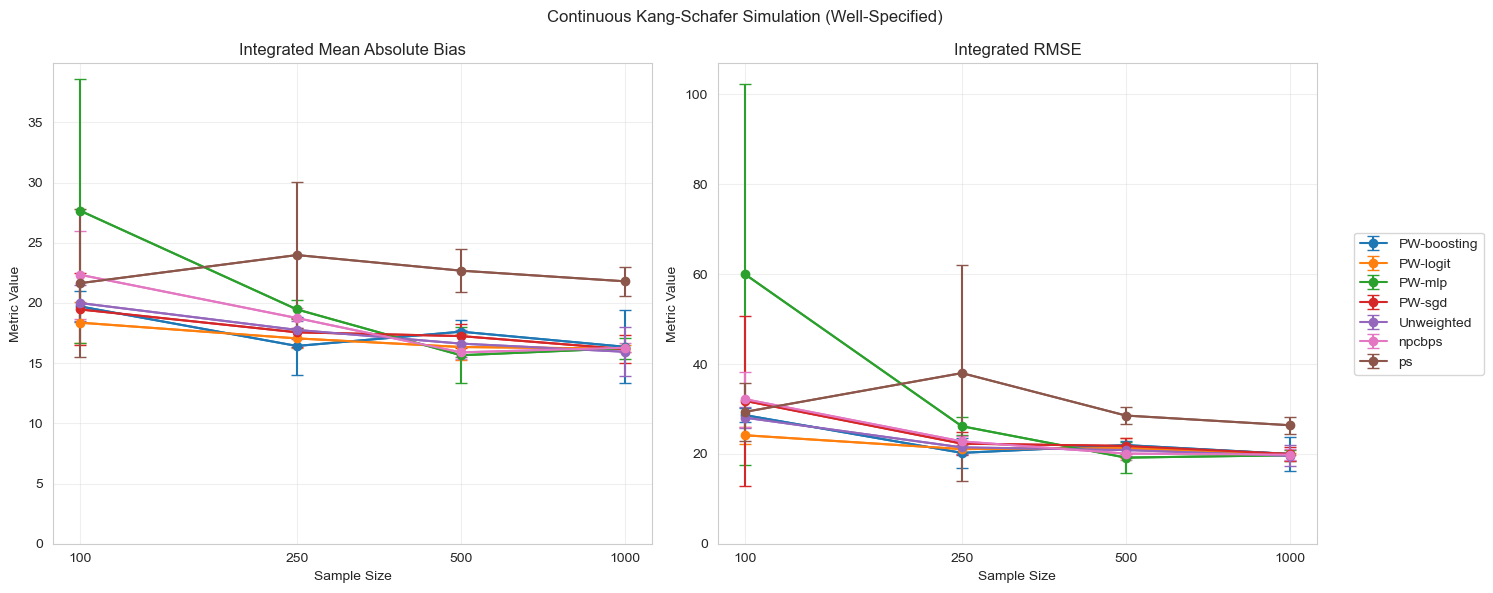

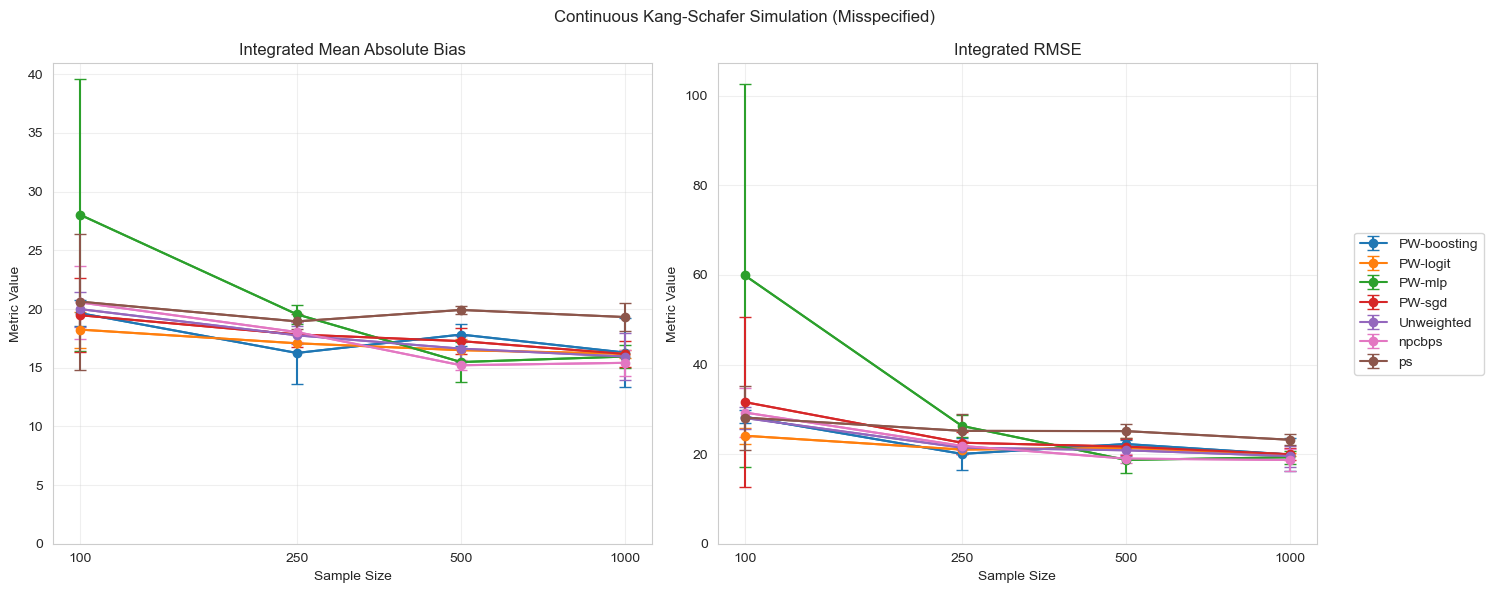

In [1]:
"""
Continuous Kang-Schafer simulation script that works with the fixed package code.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import time

# Import the PW function from your package
from permutation_weighting.estimator import PW

def create_kang_schafer_continuous_dgp(n, misspecified=False, extraneous_covs=0, trt_noise_sd=1, logit=True):
    """
    Generate data according to Kang and Schafer (2007) simulation with continuous treatment.
    """
    # Generate true covariates
    sigma = np.eye(4 + extraneous_covs)
    mus = np.zeros(4 + extraneous_covs)
    X_true = np.random.multivariate_normal(mus, sigma, n)
    
    # Coefficients for treatment
    co = np.zeros(4 + extraneous_covs)
    co[:4] = np.array([1, -0.5, 0.25, 0.1])
    
    # Linear predictor for treatment
    z_score = np.dot(X_true, co)
    
    # Treatment function - IMPORTANT: match R code exactly
    # R uses 1/(1+exp(z)) which DECREASES as z increases
    trt_fn = lambda z: 1 / (1 + np.exp(z)) if logit else z
    
    # True outcome (without treatment effect)
    Outcome = 210 + 27.4 * X_true[:, 0] + 13.7 * X_true[:, 1] + 13.7 * X_true[:, 2] + 13.7 * X_true[:, 3]
    
    # Random noise for outcome
    outcome_noise = np.random.normal(0, 1, n)
    
    # Function to draw dosage
    def draw_dose():
        noise = np.random.normal(0, trt_noise_sd, n)
        return z_score + noise
    
    # Function to calculate test points
    def draw_test_points(n_points):
        q = np.linspace(0.05, 0.95, n_points)
        Vz_score = np.dot(np.dot(co, sigma), co)
        Ez_score = np.sum(mus * co)
        test_noise = norm.ppf(q, loc=Ez_score, scale=np.sqrt(Vz_score) + trt_noise_sd)
        return Ez_score + test_noise
    
    # Function to draw outcomes
    def draw_outcome(A):
        return Outcome + trt_fn(A) + outcome_noise
    
    # Generate observed covariates (potentially misspecified)
    if misspecified:
        X = np.column_stack([
            np.exp(X_true[:, 0] / 2),
            X_true[:, 1] * (1 + np.exp(X_true[:, 0])) ** (-1) + 10,
            (X_true[:, 0] * X_true[:, 2] / 25 + 0.6) ** 3,
            (X_true[:, 1] + X_true[:, 3] + 20) ** 2
        ])
        
        # Add extraneous covariates if specified
        if extraneous_covs > 0:
            X = np.column_stack([X, X_true[:, 4:]])
    else:
        X = X_true.copy()
    
    return {
        'draw_dose': draw_dose,
        'draw_outcome': draw_outcome,
        'draw_test_points': draw_test_points,
        'data': X,
        'X': X,
        'X_true': X_true,
        'Outcome': Outcome,
        'trt_fn': trt_fn,
        'z_score': z_score,
        'outcome_noise': outcome_noise
    }

def compute_weights_continuous(X, A, method):
    """
    Compute weights for continuous treatment using various methods.
    """
    n = len(A)
    
    if method == 'Unweighted':
        return np.ones(n)
    
    elif method == 'ps':
        # Implement GPS - generalized propensity score
        model = LinearRegression()
        model.fit(X, A)
        predicted_A = model.predict(X)
        
        # Estimate conditional variance
        residuals = A - predicted_A
        sigma = np.std(residuals)
        
        # GPS weights properly stabilized
        weights = norm.pdf(A, predicted_A, sigma)
        marginal_density = norm.pdf(A, np.mean(A), np.std(A))
        weights = weights / marginal_density
        
        # Normalize and stabilize
        weights = np.clip(weights, np.percentile(weights, 1), np.percentile(weights, 99))
        weights = weights / np.mean(weights) * n
        
        return weights
    
    elif method == 'npcbps':
        # NPCBPS implementation for continuous treatment
        from sklearn.preprocessing import PolynomialFeatures
        
        # Create polynomial features (interactions) to balance
        poly = PolynomialFeatures(degree=2, include_bias=False)
        X_poly = poly.fit_transform(X)
        
        # Fit model for treatment
        model = LinearRegression()
        model.fit(X, A)
        predicted_A = model.predict(X)
        
        # Initial weights from density ratio
        residuals = A - predicted_A
        sigma = np.std(residuals)
        weights = norm.pdf(A, predicted_A, sigma)
        weights = weights / np.mean(weights) * n
        
        # Iteratively adjust weights to balance covariates
        for _ in range(5):
            # Calculate weighted moments
            w_norm = weights / np.sum(weights)
            weighted_moments = np.sum(X_poly * w_norm[:, np.newaxis], axis=0)
            unweighted_moments = np.mean(X_poly, axis=0)
            
            # Calculate imbalance
            imbalance = weighted_moments - unweighted_moments
            
            # Update weights using exponential tilting
            # Clip adjustment to prevent numerical issues
            adjustment_factors = np.sum(X_poly * imbalance, axis=1)
            adjustment_factors = np.clip(adjustment_factors, -10, 10)
            adjustment = np.exp(-0.01 * adjustment_factors)
            weights = weights * adjustment
            
            # Normalize weights
            weights = weights / np.mean(weights) * n
        
        # Final stabilization
        weights = np.clip(weights, np.percentile(weights, 1), np.percentile(weights, 99))
        weights = weights / np.mean(weights) * n
        
        return weights
    
    elif method.startswith('PW-'):
        # Extract classifier type
        classifier = method.split('-')[1]
        
        # Use the PW implementation with fixed code
        # IMPORTANT: For continuous treatments, always use bootstrap=True
        result = PW(A, X, classifier=classifier, num_replicates=10, 
                    estimand_params={'bootstrap': True})
        
        weights = result['weights']
        
        # Normalize and stabilize weights
        weights = np.clip(weights, np.percentile(weights, 1), np.percentile(weights, 99))
        weights = weights / np.mean(weights) * n
        
        return weights
    
    else:
        raise ValueError(f"Unknown method: {method}")

def local_polynomial_smooth(x, y, weights, test_points, bandwidth=0.2, degree=2):
    """
    Perform local polynomial smoothing with weights.
    """
    from sklearn.linear_model import LinearRegression
    
    predictions = []
    x_std = np.std(x)
    
    for test_x in test_points:
        # Calculate kernel weights based on distance
        kernel_weights = np.exp(-0.5 * ((x - test_x) / (bandwidth * x_std))**2)
        
        # Combine with sample weights
        combined_weights = kernel_weights * weights
        
        # Skip points with no effective weight
        if np.sum(combined_weights) < 1e-10:
            predictions.append(np.mean(y))
            continue
        
        # Create polynomial features
        X_poly = np.column_stack([x**i for i in range(degree+1)])
        
        # Fit weighted linear regression
        model = LinearRegression()
        model.fit(X_poly, y, sample_weight=combined_weights)
        
        # Predict at test point
        test_poly = np.array([[test_x**i for i in range(degree+1)]])
        predictions.append(model.predict(test_poly)[0])
    
    return np.array(predictions)

def evaluate_continuous_treatment_effect(dgp, weights, test_points):
    """
    Evaluate continuous treatment effect estimation.
    """
    # Generate data
    A = dgp['draw_dose']()
    Y = dgp['draw_outcome'](A)
    X = dgp['X']
    
    # Calculate true dose-response at test points
    true_effects = []
    for a in test_points:
        uniform_A = np.repeat(a, len(A))
        true_effects.append(np.mean(dgp['draw_outcome'](uniform_A)))
    
    # Normalize weights
    weights = weights / np.sum(weights) * len(weights)
    
    # Create data for SIPW
    df_sipw = pd.DataFrame({
        'Dose': A,
        'Outcome': Y,
        'weights': weights
    })
    
    # Fit outcome model for Direct Method (DM)
    X_with_dose = np.column_stack([A.reshape(-1, 1), X])
    
    # OLS with weights
    ols_model = LinearRegression()
    ols_model.fit(X_with_dose, Y, sample_weight=weights)
    
    # Get predictions for DM
    predicted_Y = ols_model.predict(X_with_dose)
    
    # Calculate residuals for DR
    residuals = Y - predicted_Y
    
    # Create data frames for DM and DR
    df_dm = pd.DataFrame({
        'Dose': A,
        'Outcome': predicted_Y,
        'weights': np.ones(len(A))
    })
    
    df_dr = pd.DataFrame({
        'Dose': A,
        'Outcome': predicted_Y + residuals,
        'weights': weights
    })
    
    # Use local polynomial smoothing for each approach
    estimated_effects_sipw = local_polynomial_smooth(
        df_sipw['Dose'], df_sipw['Outcome'], df_sipw['weights'], 
        test_points, bandwidth=0.15, degree=1
    )
    
    estimated_effects_dm = local_polynomial_smooth(
        df_dm['Dose'], df_dm['Outcome'], df_dm['weights'], 
        test_points, bandwidth=0.15, degree=1
    )
    
    estimated_effects_dr = local_polynomial_smooth(
        df_dr['Dose'], df_dr['Outcome'], df_dr['weights'], 
        test_points, bandwidth=0.15, degree=1
    )
    
    # Calculate differences for each method
    true_effects = np.array(true_effects)
    diffs_sipw = estimated_effects_sipw - true_effects
    diffs_dm = estimated_effects_dm - true_effects
    diffs_dr = estimated_effects_dr - true_effects
    
    # Calculate bias and RMSE for SIPW
    bias_sipw = np.mean(np.abs(diffs_sipw))
    rmse_sipw = np.sqrt(np.mean(diffs_sipw**2))
    
    # Return SIPW metrics for compatibility with the paper
    return {
        'bias': bias_sipw,
        'rmse': rmse_sipw,
        'diffs_sipw': diffs_sipw,
        'true_effects': true_effects,
        'estimated_effects_sipw': estimated_effects_sipw,
        'test_points': test_points
    }

def run_kang_schafer_continuous_simulation(sample_sizes=None, n_sims=48, methods=None, misspecified=False):
    """
    Run continuous Kang-Schafer simulation.
    """
    if sample_sizes is None:
        sample_sizes = [100, 250, 500, 1000, 2000]
    
    if methods is None:
        methods = ['Unweighted', 'ps', 'npcbps', 'PW-logit', 'PW-boosting', 'PW-sgd', 'PW-mlp']
    
    results = []
    
    print(f"Running {'misspecified' if misspecified else 'well-specified'} continuous Kang-Schafer simulation...")
    
    for n in sample_sizes:
        print(f"  Sample size: {n}")
        
        for sim in range(n_sims):
            if sim % 5 == 0:
                print(f"    Simulation {sim+1}/{n_sims}")
                
            # Create data generating process with fixed seed for reproducibility
            np.random.seed(100 + sim)
            dgp = create_kang_schafer_continuous_dgp(n, misspecified=misspecified)
            
            # Generate test points
            test_points = dgp['draw_test_points'](20)
            
            # Generate data for this simulation
            A = dgp['draw_dose']()
            X = dgp['X']
            
            for method in methods:
                try:
                    # Time the weight computation
                    start_time = time.time()
                    weights = compute_weights_continuous(X, A, method)
                    weight_time = time.time() - start_time
                    
                    # Evaluate treatment effect
                    eval_results = evaluate_continuous_treatment_effect(dgp, weights, test_points)
                    
                    # Store results
                    results.append({
                        'sample_size': n,
                        'simulation': sim,
                        'method': method,
                        'bias': eval_results['bias'],
                        'rmse': eval_results['rmse'],
                        'time': weight_time
                    })
                    
                except Exception as e:
                    print(f"    Error with method {method} on simulation {sim} with n={n}: {e}")
    
    return pd.DataFrame(results)

def plot_continuous_ks_results(results, title):
    """
    Plot results similar to the paper.
    """
    # Bootstrap for robust estimates of means and standard errors
    n_bootstrap = 5
    bootstrap_results = []
    
    for _ in range(n_bootstrap):
        # Sample simulations with replacement
        bootstrap_indices = np.random.choice(
            results.index, size=len(results), replace=True
        )
        bootstrap_sample = results.iloc[bootstrap_indices]
        
        # Calculate means for this bootstrap sample
        bootstrap_means = bootstrap_sample.groupby(['method', 'sample_size']).agg({
            'bias': 'mean', 
            'rmse': 'mean'
        })
        
        bootstrap_results.append(bootstrap_means)
    
    # Combine bootstrap results
    all_bootstrap = pd.concat(bootstrap_results)
    
    # Calculate mean and standard error across bootstraps
    agg_data = all_bootstrap.groupby(['method', 'sample_size']).agg({
        'bias': ['mean', 'std'],
        'rmse': ['mean', 'std']
    }).reset_index()
    
    # Rename columns for easier access
    agg_data.columns = ['method', 'sample_size', 'bias_mean', 'bias_sem', 'rmse_mean', 'rmse_sem']
    
    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Set a consistent color palette
    palette = {
        'PW-boosting': '#1f77b4',  # blue
        'PW-logit': '#ff7f0e',       # orange
        'PW-mlp': '#2ca02c',       # green
        'PW-sgd': '#d62728',       # red
        'Unweighted': '#9467bd',   # purple
        'ps': '#8c564b',           # brown
        'npcbps': '#e377c2'        # pink
    }
    
    # Plot for each method
    for method in agg_data['method'].unique():
        method_data = agg_data[agg_data['method'] == method]
        
        # Plot Integrated Mean Absolute Bias
        axes[0].errorbar(
            method_data['sample_size'],
            method_data['bias_mean'],
            yerr=method_data['bias_sem'] * 1.96,  # 95% CI
            marker='o',
            label=method,
            capsize=4,
            color=palette.get(method, None)
        )
        
        # Connect points with lines
        axes[0].plot(
            method_data['sample_size'],
            method_data['bias_mean'],
            color=palette.get(method, None)
        )
        
        # Plot Integrated RMSE
        axes[1].errorbar(
            method_data['sample_size'],
            method_data['rmse_mean'],
            yerr=method_data['rmse_sem'] * 1.96,  # 95% CI
            marker='o',
            label=method,
            capsize=4,
            color=palette.get(method, None)
        )
        
        # Connect points with lines
        axes[1].plot(
            method_data['sample_size'],
            method_data['rmse_mean'],
            color=palette.get(method, None)
        )
    
    # Set titles and labels
    axes[0].set_title('Integrated Mean Absolute Bias')
    axes[0].set_xlabel('Sample Size')
    axes[0].set_ylabel('Metric Value')
    
    axes[1].set_title('Integrated RMSE')
    axes[1].set_xlabel('Sample Size')
    axes[1].set_ylabel('Metric Value')
    
    # Set y-axis limits to start from 0
    axes[0].set_ylim(0, None)
    axes[1].set_ylim(0, None)
    
    # Set x-axis to log scale
    for ax in axes:
        ax.set_xscale('log')
        ax.set_xticks(sorted(agg_data['sample_size'].unique()))
        ax.set_xticklabels(sorted(agg_data['sample_size'].unique()))
        ax.grid(True, alpha=0.3)
    
    # Add legend to the right of the plot
    axes[1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.suptitle(title)
    plt.tight_layout()
    
    # Save figure
    spec_type = "misspecified" if "Misspecified" in title else "wellspecified"
    plt.savefig(f'continuous_ks_package_{spec_type}.png', dpi=300, bbox_inches='tight')
    
    return fig

def main():
    """
    Run the continuous Kang-Schafer simulations.
    """
    # Use smaller configuration for testing
    test_mode = True
    
    if test_mode:
        sample_sizes = [100, 250, 500, 1000]
        n_sims = 5  # Reduced for testing
        methods = ['Unweighted', 'ps', 'npcbps', 'PW-logit', 'PW-boosting', 'PW-sgd', 'PW-mlp']
    else:
        sample_sizes = [100, 250, 500, 1000, 2000, 5000]
        n_sims = 5  # Same as in the paper
        methods = ['Unweighted', 'ps', 'npcbps', 'PW-logit', 'PW-boosting', 'PW-sgd', 'PW-mlp']
    
    # Run well-specified simulation
    start_time = time.time()
    well_specified_results = run_kang_schafer_continuous_simulation(
        sample_sizes=sample_sizes,
        n_sims=n_sims,
        methods=methods,
        misspecified=False
    )
    print(f"Well-specified simulation completed in {time.time() - start_time:.1f} seconds")
    
    # Plot well-specified results
    fig1 = plot_continuous_ks_results(
        well_specified_results,
        "Continuous Kang-Schafer Simulation (Well-Specified)"
    )
    
    # Run misspecified simulation
    start_time = time.time()
    misspecified_results = run_kang_schafer_continuous_simulation(
        sample_sizes=sample_sizes,
        n_sims=n_sims,
        methods=methods,
        misspecified=True
    )
    print(f"Misspecified simulation completed in {time.time() - start_time:.1f} seconds")

    # Plot misspecified results
    fig2 = plot_continuous_ks_results(
        misspecified_results,
        "Continuous Kang-Schafer Simulation (Misspecified)"
    )
    
    return {
        'well_specified_results': well_specified_results,
         'misspecified_results': misspecified_results,
         'figures': [fig1, fig2]
    }

if __name__ == "__main__":
    results = main()